# Feature Creation HealthCare Data

* Motivation:

HealthCare continues to be a theme for debate in the US. How much should the government subsidize healthcare? Are prices for medical services too expensive? Should the government have a bigger grip on prices for medicine? These are topics that have been under discussion for decades and most solutions fall into the pit of never achieving bipartisan support. The system, therefore, is broken, which leaves private companies and hospitals with the power to decide how to manage this turbulent system. On the other side of the spectrum, there seems to be some general discontent by customers about the system who argue that the current system is unevenly balanced in favor of HealthCare companies.
On top of all these issues, fraudulent claims are on the raise as we move towards a more digitalized era. For this piece I will delve into data provided by the Centers for Medicare & Medicaid Services (CMS) in order to understand the system and pinpoint observations that need to be observed more in depth. 

* Resources:
        
        *Data on HealthCare costs provided by the CMS.
        *Data Visualizations with Seaborn, Plotly and Matplotlib
        *Data Aggregation and Clustering Analysis
        
* Methods:
        
        *Bin creation Based on Quantiles
        *Creating Flags for Unusual Behaviors.
        *K-Means Clustering to Cluster Providers.
        
* Objective:

By using several feature engineering and data visualization techniques, create a framework for detecting fraud on a dataset of HealthCare costs aggregated by providers.

In [561]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from math import isnan


pio.renderers.default = 'png'
os.chdir("/Users/luislosada/Columbia Drive/Anomaly Detection/Module 4")


In [17]:
data = pd.read_csv('Inpatient_Prospective_Payment_System__IPPS__Provider_Summary_for_All_Diagnosis-Related_Groups__DRG__-_FY2015.csv')


In [18]:
#dropping redundant variables, this variable is just a combination of the State and City Variables.
data.drop(columns=["Hospital Referral Region (HRR) Description"],inplace=True)
list(data.columns)


['DRG Definition',
 'Provider Id',
 'Provider Name',
 'Provider Street Address',
 'Provider City',
 'Provider State',
 'Provider Zip Code',
 'Total Discharges',
 'Average Covered Charges',
 'Average Total Payments',
 'Average Medicare Payments']

In [23]:
#Lets see the stats of the continuous variables
def stat_flat(data,group_var,cont_var):
    coln =list(data[[group_var,cont_var]].describe().index)
    row = data[[group_var]].drop_duplicates().reset_index(drop=True).values.tolist()
    row = [item for sublist in row for item in sublist] #faltten the list
    desc_cont_var = pd.DataFrame(data[[group_var,cont_var]].groupby(group_var).describe().values.tolist(), columns=coln,index=row)
    return desc_cont_var
stat_flat(data,"DRG Definition","Average Covered Charges").head(n=10)

,count,mean,std,min,25%,50%,75%,max
001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,74.0,959194.801486,475938.819681,382051.00,668049.2850,813961.555,1.124541e+06,2794183.75
"003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NECK W MAJ O.R.",407.0,544034.771474,308294.794010,105785.45,358850.6950,472291.000,6.627527e+05,2786294.94
038 - EXTRACRANIAL PROCEDURES W CC,549.0,328518.807905,191028.360012,49077.00,205726.8900,275698.310,3.992861e+05,2085826.85
039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,46.0,479120.261522,230074.853587,143217.39,341243.9800,418957.405,5.065289e+05,1260826.53
"004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH & NECK W/O MAJ O.R.",3.0,230312.076667,41911.157781,186297.18,210596.8400,234896.500,2.523195e+05,269742.55
005 - LIVER TRANSPLANT W MCC OR INTESTINAL TRANSPLANT,21.0,563212.282857,281717.152275,180838.62,371113.1800,479738.330,6.117755e+05,1182539.71
006 - LIVER TRANSPLANT W/O MCC,8.0,378086.325000,77989.829869,303179.36,323521.3500,354728.605,3.993642e+05,507488.36
007 - LUNG TRANSPLANT,34.0,181600.048235,85112.806796,86271.82,124072.9800,165445.200,2.184490e+05,459821.23
008 - SIMULTANEOUS PANCREAS/KIDNEY TRANSPLANT,54.0,134986.987963,64561.032650,57901.46,96472.2975,121416.855,1.441063e+05,364334.45
"011 - TRACHEOSTOMY FOR FACE,MOUTH & NECK DIAGNOSES W MCC",4.0,85785.110000,35474.671912,52471.87,58496.6275,81569.440,1.088579e+05,127529.69


In [20]:
stat_flat(data,"DRG Definition","Average Total Payments").head(n=10)


,count,mean,std,min,25%,50%,75%,max
001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,74.0,253942.444189,66369.123846,164439.47,201303.5325,240426.025,290259.2950,449486.11
"003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NECK W MAJ O.R.",407.0,135509.606880,45135.047106,64872.40,104163.9650,127730.390,155554.0650,372445.03
038 - EXTRACRANIAL PROCEDURES W CC,549.0,77695.447505,24700.130967,36871.82,59103.4600,71986.080,90847.5400,178488.22
039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,46.0,120902.756304,42516.151891,65210.55,92416.9375,112184.755,132140.0075,292498.30
"004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH & NECK W/O MAJ O.R.",3.0,49424.340000,10837.554575,39483.56,43647.5550,47811.550,54394.7300,60977.91
005 - LIVER TRANSPLANT W MCC OR INTESTINAL TRANSPLANT,21.0,108764.685238,29426.890469,61361.85,88279.2400,101889.380,123804.6700,182275.18
006 - LIVER TRANSPLANT W/O MCC,8.0,73645.088750,15496.831187,54886.55,61158.0750,74883.435,87345.0025,90178.86
007 - LUNG TRANSPLANT,34.0,48310.213235,12900.403208,26743.00,39232.2275,45755.820,51593.8750,90106.52
008 - SIMULTANEOUS PANCREAS/KIDNEY TRANSPLANT,54.0,33850.138704,9034.785707,19193.71,27564.5475,32028.760,36979.9700,67189.94
"011 - TRACHEOSTOMY FOR FACE,MOUTH & NECK DIAGNOSES W MCC",4.0,20638.807500,4450.538348,14704.87,19060.2625,21237.065,22815.6100,25376.23


In [21]:
stat_flat(data,"DRG Definition","Average Medicare Payments").head(n=10)


,count,mean,std,min,25%,50%,75%,max
001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,74.0,217710.299595,59111.069664,120839.23,180567.2900,200700.360,240206.2100,417977.35
"003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NECK W MAJ O.R.",407.0,122064.120369,38390.987448,51699.00,95767.3300,115832.060,140148.9650,350781.23
038 - EXTRACRANIAL PROCEDURES W CC,549.0,70347.235756,21033.259624,35082.41,55369.5200,65735.170,80894.8500,156453.98
039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,46.0,97606.521304,37657.927919,44443.73,75561.0575,88856.080,105422.8850,233339.14
"004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH & NECK W/O MAJ O.R.",3.0,33779.530000,5195.306447,28094.50,31528.8850,34963.270,36622.0450,38280.82
005 - LIVER TRANSPLANT W MCC OR INTESTINAL TRANSPLANT,21.0,82875.740952,25015.328747,57095.85,65684.4100,72808.000,94841.8800,152154.15
006 - LIVER TRANSPLANT W/O MCC,8.0,43338.326250,10611.303557,28711.14,35360.9550,44406.420,51337.6575,57053.08
007 - LUNG TRANSPLANT,34.0,41390.594412,12191.041711,24691.67,33746.6225,39168.470,45006.8025,86174.43
008 - SIMULTANEOUS PANCREAS/KIDNEY TRANSPLANT,54.0,27928.542593,8344.297802,18032.08,22372.1550,26236.615,29758.5650,62962.00
"011 - TRACHEOSTOMY FOR FACE,MOUTH & NECK DIAGNOSES W MCC",4.0,16825.052500,2869.435887,13469.93,15187.9025,16833.740,18470.8900,20162.80


### Data Visualization

I'll start by using several data visualization tools to graps some insight into the dataset. With this I am hoping to answer quetions regarding costs and how location affects it.

First lets take a look at how each of our cost variables differs from state to state:

In [76]:
def plot_map_USA(data,group_var,cont_var,stat, label = " in Thousands",color = 'Reds'):
    #Grouping the Data
    p1 = stat_flat(data,group_var,cont_var)
    
    #Plotting Heat Map of Total Discharge by State
    fig = go.Figure(data=go.Choropleth(
        locations=list(p1[stat].index), # Spatial coordinates
        z = p1[stat].astype(float), # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = color,
        colorbar_title = stat + label.lower(),
    ))
    
    fig.update_layout(
        title_text = list(data[[cont_var]].columns)[0]+" Per State",
        geo_scope='usa', # limit map scope to USA
    )
    
    return fig



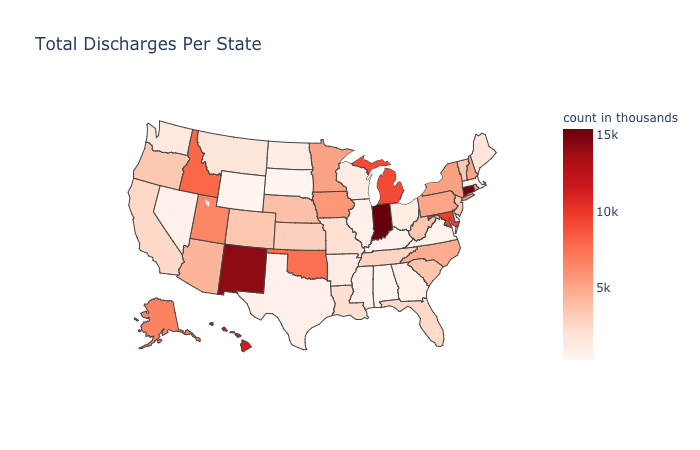

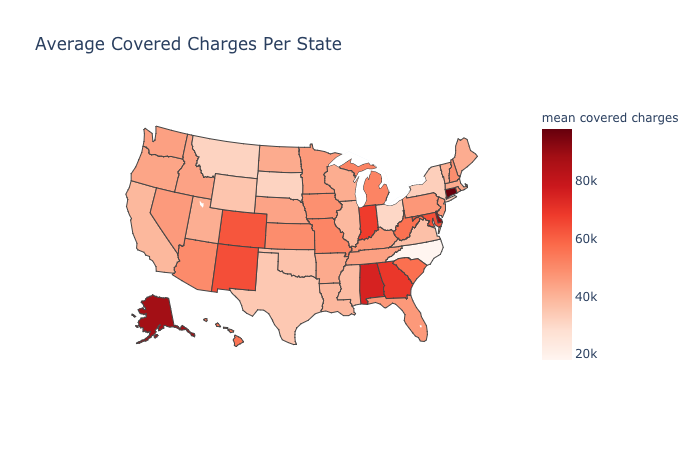

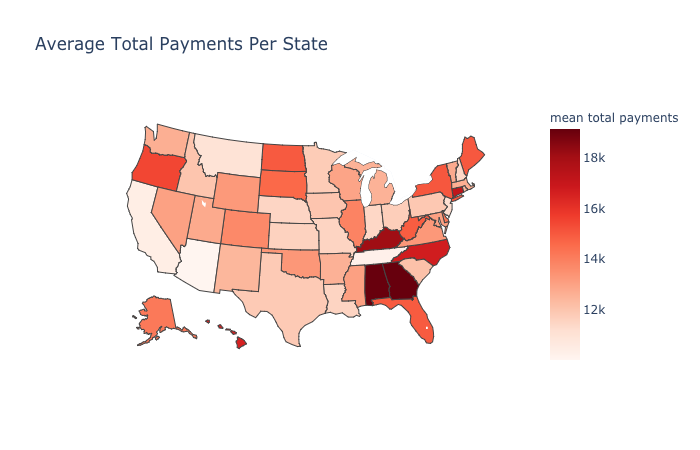

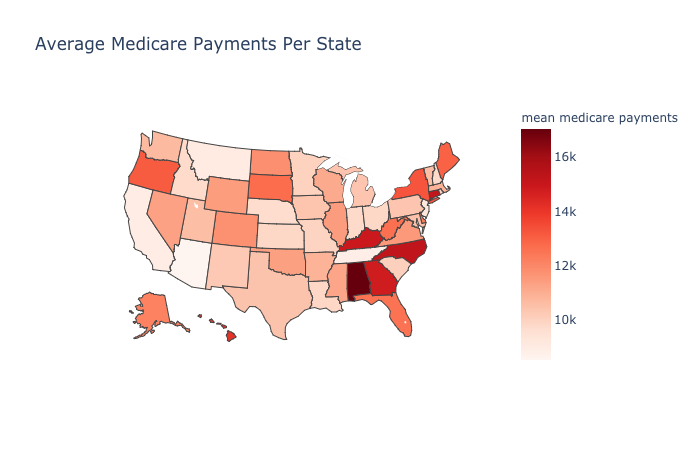

In [77]:
#Further Exploration
p = [plot_map_USA(data,"Provider State","Total Discharges","count"),plot_map_USA(data,"Provider State","Average Covered Charges","mean",label=" covered charges"),
    plot_map_USA(data,"Provider State","Average Total Payments","mean",label=" Total Payments"),plot_map_USA(data,"Provider State","Average Medicare Payments","mean",label=" Medicare Payments")]

for i in range(len(p)):
    p[i].show()
     


A good framework for detecting fraud is identifying instances of high volume of claims of the same type all the time. 
This obviously has its limitations because some hospitals specialize in certain procedures so volumes of that procedure 
might be out of the ordinary. But lets see what we can find.



In [163]:
#What pecentage of the avg amount charged was not payed by medicare.  
data['charge_vs_medic'] = round((1 - (data['Average Covered Charges'] - data['Average Medicare Payments'])/data['Average Covered Charges'])*100,2)
data['charge_vs_medic'].describe()


count    201876.000000
mean         25.028002
std          15.431120
min           2.380000
25%          15.550000
50%          21.550000
75%          29.500000
max        1150.400000
Name: charge_vs_medic, dtype: float64

In [208]:
def bins_creator(data,var,n):
    bins = np.linspace(0, 100, n)
    ranges = [(bins[i], bins[i + 1]) for i in range(len(bins) - 1)]
    data['Bining'] = [0 for i in range(len(data))]
    for i in range(len(ranges)):
        for j in range(len(data)):
            if int(data.loc[j,var]) in range(int(ranges[i][0]),int(ranges[i][1])):
                data.loc[j,"Bining"] = ["perc_" +str(round(ranges[i][0]))+"_"+str(round(ranges[i][1]))][0]
    return data
Df_exp = bins_creator(data,'charge_vs_medic',10)


In [209]:
cnt_per_bin = Df_exp.groupby(['DRG Definition','Bining']).size().to_frame(name = 'count').reset_index()
cnt_per_bin.head(20)


,DRG Definition,Bining,count
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,perc_0.0_11.0,2
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,perc_11.0_22.0,26
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,perc_22.0_33.0,32
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,perc_33.0_44.0,12
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,perc_44.0_56.0,2
5,003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FA...,perc_0.0_11.0,8
6,003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FA...,perc_11.0_22.0,149
7,003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FA...,perc_22.0_33.0,179
8,003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FA...,perc_33.0_44.0,47
9,003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FA...,perc_44.0_56.0,14


In [210]:
#Hot Encoding the bins:
lb = LabelBinarizer()
lb_results = lb.fit_transform(Df_exp['Bining'].apply(str))
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
lb_results_df.head(10)
 
DF = Df_exp.join(lb_results_df)


In [221]:
DF["perc_0.0_11.0"].loc[np.where(DF["0"] == 1)] = 1
DF.drop(["0"],axis=1,inplace=True)


/Library/Python/3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Now I'll create a ranking system by state and covered charges. Lets see how expensive is each procedure per state.  

In [243]:
xx= DF.groupby(['DRG Definition','Provider State'])['Average Covered Charges'].describe() 
xx.reset_index(inplace=True)
for_rank = xx[['DRG Definition',"Provider State","mean"]]


In [394]:
df2=pd.DataFrame(for_rank.pivot(index='Provider State', columns='DRG Definition', values='mean').reset_index().rename_axis(None))


In [412]:
col = list(df2.columns[1:len(df2.columns)])
dff_rank = pd.DataFrame(index=list(df2["Provider State"]),columns=col)
for state in range(len(df2)):
    dff_rank.iloc[state,] = df2.iloc[state,1:].rank(ascending = 1)
dff_rank.iloc[:,0:20]

,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,"003 - ECMO OR TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NECK W MAJ O.R.","004 - TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH & NECK W/O MAJ O.R.",005 - LIVER TRANSPLANT W MCC OR INTESTINAL TRANSPLANT,006 - LIVER TRANSPLANT W/O MCC,007 - LUNG TRANSPLANT,008 - SIMULTANEOUS PANCREAS/KIDNEY TRANSPLANT,"011 - TRACHEOSTOMY FOR FACE,MOUTH & NECK DIAGNOSES W MCC","012 - TRACHEOSTOMY FOR FACE,MOUTH & NECK DIAGNOSES W CC","013 - TRACHEOSTOMY FOR FACE,MOUTH & NECK DIAGNOSES W/O CC/MCC",014 - ALLOGENEIC BONE MARROW TRANSPLANT,016 - AUTOLOGOUS BONE MARROW TRANSPLANT W CC/MCC,017 - AUTOLOGOUS BONE MARROW TRANSPLANT W/O CC/MCC,020 - INTRACRANIAL VASCULAR PROCEDURES W PDX HEMORRHAGE W MCC,023 - CRANIO W MAJOR DEV IMPL/ACUTE COMPLEX CNS PDX W MCC OR CHEMO IMPLANT,024 - CRANIO W MAJOR DEV IMPL/ACUTE COMPLEX CNS PDX W/O MCC,025 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDURES W MCC,026 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDURES W CC,027 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDURES W/O CC/MCC,028 - SPINAL PROCEDURES W MCC
AK,NaN,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL,367,365,363,364,NaN,NaN,NaN,352,320,306,366,361,NaN,360,341,NaN,296,266,295,337
AR,NaN,293,286,NaN,NaN,NaN,NaN,257,230,NaN,NaN,290,NaN,289,263,240,256,237,204,NaN
AZ,297,298,291,290,NaN,299,NaN,253,255,NaN,293,257,NaN,NaN,262,259,256,237,211,284
CA,409,408,400,407,NaN,406,396,350,358,NaN,402,390,NaN,404,377,329,351,306,288,NaN
CO,280,276,270,274,NaN,277,NaN,NaN,NaN,NaN,278,266,NaN,279,268,261,240,229,223,NaN
CT,340,339,336,NaN,NaN,NaN,NaN,333,293,NaN,334,NaN,NaN,338,311,NaN,292,273,248,322
DC,276,275,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,253,NaN,250,237,198,NaN
DE,NaN,322,321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307,294,293,258,273,297
FL,456,454,450,453,NaN,455,452,447,432,NaN,NaN,420,NaN,437,424,406,407,347,329,NaN


In [391]:
#Lets Look at NY rank of Average Covered Charges
print(dff_rank.loc["NY",].sort_values().head(40))


775 - VAGINAL DELIVERY W/O COMPLICATING DIAGNOSES                             1
882 - NEUROSES EXCEPT DEPRESSIVE                                              2
774 - VAGINAL DELIVERY W COMPLICATING DIAGNOSES                               3
894 - ALCOHOL/DRUG ABUSE OR DEPENDENCE, LEFT AMA                              4
881 - DEPRESSIVE NEUROSES                                                     5
090 - CONCUSSION W/O CC/MCC                                                   6
781 - OTHER ANTEPARTUM DIAGNOSES W MEDICAL COMPLICATIONS                      7
765 - CESAREAN SECTION W CC/MCC                                               8
310 - CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS W/O CC/MCC                    9
313 - CHEST PAIN                                                             10
868 - OTHER INFECTIOUS & PARASITIC DISEASES DIAGNOSES W CC                   11
293 - HEART FAILURE & SHOCK W/O CC/MCC                                       12
714 - TRANSURETHRAL PROSTATECTOMY W/O CC

Text(0.5, 418.0199999999999, 'DRG Definition Id')

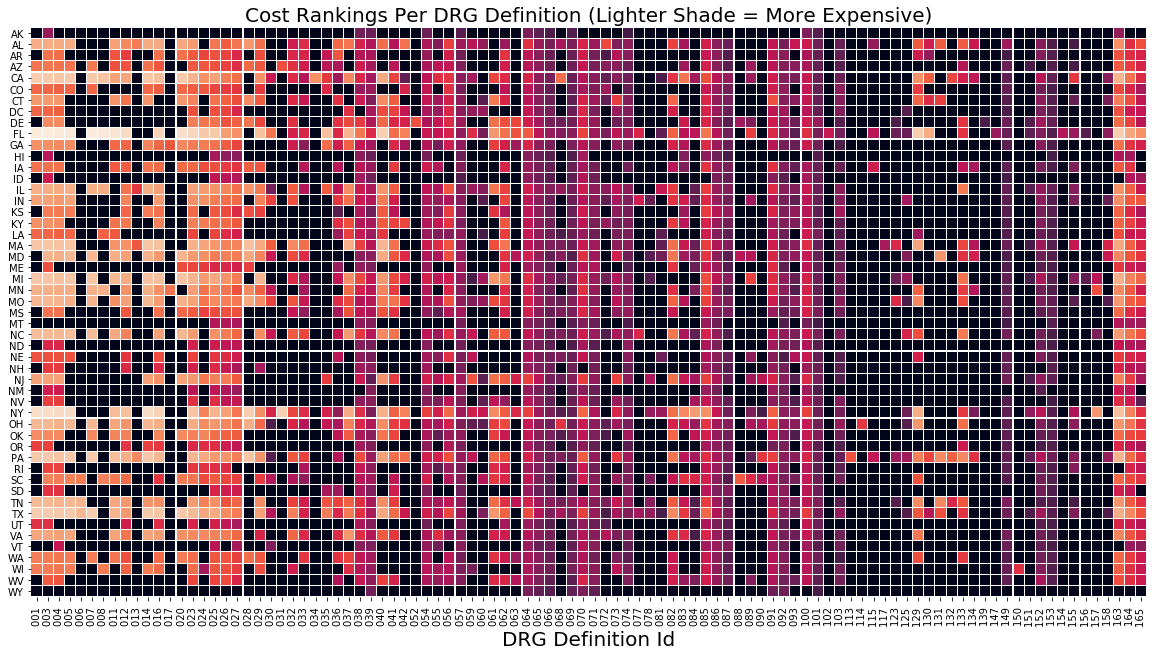

In [400]:
#Lets Compare Now
#shorten the Id
df_rank = dff_rank.fillna(-100)
col_id = [col[m].split("-")[0] for m in range(len(col))]
df_rank.columns = col_id

#Plot
plt.figure(figsize=(20,20))
sns.heatmap(df_rank.iloc[:,0:100], square=True, vmin=-100, cbar=False, linewidths=0.1)
plt.title("Cost Rankings Per DRG Definition (Lighter Shade = More Expensive)", fontsize=20)
plt.xlabel("DRG Definition Id", fontsize=20)


This plot tells us that the hottest (or most expensive) lie around the first IDs (001 is a heart transplant so it makes sense it has the hottest squares). Also some IDs seem to have almost no participation as seen by how many cold squares there are. This graph has helped us understand the data a little bit better, lets continue and add our RANK variable to the dataset.

In [413]:
dff_rank.reset_index(level=0,inplace=True)

In [450]:
#Adding this to the data

df_rr=pd.melt(dff_rank,id_vars=['index'],var_name='DRG_Definition', value_name='values')
DF["RANK"] = 0
for o in range(len(df_rr)):
    DF.RANK = np.where((DF["Provider State"] == df_rr['index'][o]) & (DF["DRG Definition"] == df_rr['DRG_Definition'][o]) & (isnan(df_rr['values'][o]) == False), df_rr['values'][o],DF.RANK)
    


In [461]:
#Group by Provider and get count of discharges, and mean of all three main vars

for_analysis = pd.DataFrame({"Count":stat_flat(DF,"Provider Id","Total Discharges")['count'],
              "Mean_Covered_Charges":stat_flat(DF,"Provider Id","Average Covered Charges")['mean'],
              "Mean_Total_Payments":stat_flat(DF,"Provider Id","Average Total Payments")['mean'],
              "Mean_Medicare_Payments":stat_flat(DF,"Provider Id","Average Medicare Payments")['mean'],
              "Mean_Charge_vs_Medic":stat_flat(DF,"Provider Id","charge_vs_medic")['mean']})



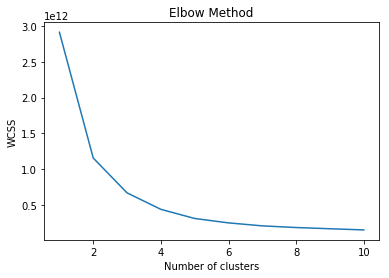

In [468]:
plt.figure(figsize=(20,20))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(for_analysis)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()




In [470]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(for_analysis)

tsne_model = TSNE(perplexity=100, n_components=2, init='pca',metric='cosine', n_iter=5000, random_state=23)
new_values = tsne_model.fit_transform(for_analysis)
reduced_dimension = pd.DataFrame(new_values)
reduced_dimension['clusters'] = pd.Series(pred_y)
reduced_dimension['Provider_ID'] = list(for_analysis.index)
reduced_dimension['Provider_ID'] = list(for_analysis.index)



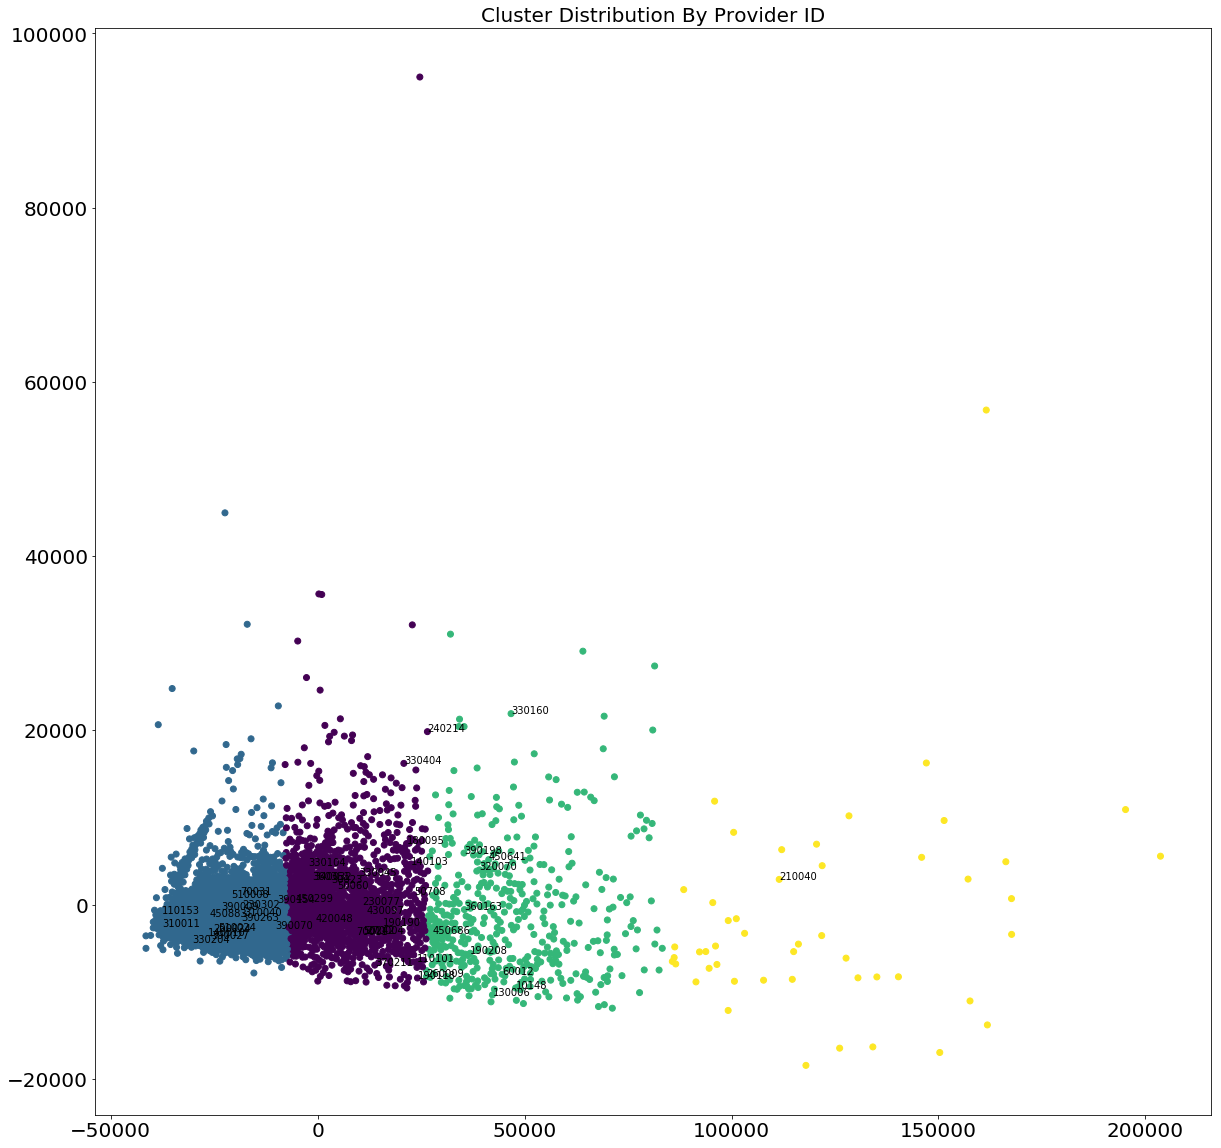

In [515]:
plt.figure(figsize=(20,20))
x=reduced_dimension.loc[:,0]
y=reduced_dimension.loc[:,1]
plt.scatter(x,y,c=reduced_dimension['clusters'])
plt.title("Cluster Distribution By Provider ID", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

red_x = pd.DataFrame(reduced_dimension.sample(50)).reset_index()
for i in range(len(red_x)):
    fx = red_x.iloc[i,1]
    fy= red_x.iloc[i,2]
    plt.annotate(red_x.Provider_ID[i],xy=(fx,fy))
plt.show()

What do these Clusters tell us? It seems like clusters 0-2 share very similar characteristics and cluster 3 seems to have only the outliers furthest away from what's common.
Lets explore these two instances. First a look at all providers above the 20,000.00 mark, then a look at everything in cluster 3.


In [519]:
#Adding our clusters to the dataset
DF["Cluster"] = 0
for i in range(len(reduced_dimension)):
    DF.Cluster = np.where((DF["Provider Id"] == reduced_dimension['Provider_ID'][i]),reduced_dimension['clusters'][i],DF.Cluster)
DF.Cluster.value_counts()



1    88077
0    75256
2    33905
3     4638
Name: Cluster, dtype: int64

In [548]:
#Everything
DF[["Total Discharges","Average Covered Charges","Average Total Payments",
    "Average Medicare Payments","charge_vs_medic","RANK","Cluster"]].describe()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,charge_vs_medic,RANK,Cluster
count,201876.000000,2.018760e+05,201876.000000,201876.000000,201876.000000,201876.000000,201876.000000
mean,36.820959,5.500866e+04,13219.565072,11213.909857,25.028002,142.604851,0.841115
std,51.525284,6.582696e+04,13835.710286,12310.955873,15.431120,102.332192,0.779352
min,11.000000,1.715000e+03,2419.490000,659.260000,2.380000,1.000000,0.000000
25%,15.000000,2.173497e+04,6260.835000,4982.402500,15.550000,57.000000,0.000000
50%,22.000000,3.605010e+04,9185.390000,7680.885000,21.550000,120.000000,1.000000
75%,39.000000,6.347406e+04,14655.012500,12442.505000,29.500000,211.000000,1.000000
max,3990.000000,2.794184e+06,449486.110000,417977.350000,1150.400000,456.000000,3.000000


In [549]:
#Only Above the 20k Mark
check_id = list(reduced_dimension[reduced_dimension.iloc[:,1]>20000]['Provider_ID'])
ym = []
for ii in range(len(check_id)):
    ll =np.where(DF["Provider Id"] == check_id[ii])
    ym.append(ll[0].tolist())
ym=[item for sublist in ym for item in sublist]

DF[["Total Discharges","Average Covered Charges","Average Total Payments",
    "Average Medicare Payments","charge_vs_medic","RANK","Cluster"]].iloc[ym,:].describe()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,charge_vs_medic,RANK,Cluster
count,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000
mean,34.778153,55251.604330,13704.721222,11745.486301,26.186250,135.636261,1.122185
std,41.740139,64360.075322,14283.889772,13390.455144,14.429977,96.283019,0.931600
min,11.000000,3525.820000,3014.530000,1676.220000,5.130000,1.000000,0.000000
25%,14.000000,20577.295000,6632.445000,5229.230000,16.620000,53.000000,0.000000
50%,22.000000,35593.485000,9338.230000,7928.605000,22.805000,118.000000,1.000000
75%,39.000000,64842.922500,15014.752500,12864.235000,31.562500,205.000000,2.000000
max,682.000000,830712.080000,228651.000000,223808.460000,95.030000,435.000000,3.000000


In [550]:
#On Cluster 3
DF[["Total Discharges","Average Covered Charges","Average Total Payments",
    "Average Medicare Payments","charge_vs_medic","RANK","Cluster"]][DF["Cluster"] == 3].describe()


,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,charge_vs_medic,RANK,Cluster
count,4638.000000,4638.000000,4638.000000,4638.000000,4638.000000,4638.000000,4638.0
mean,40.639500,60332.291041,16475.459170,14003.992934,28.821164,164.543122,3.0
std,58.174793,64456.288838,16900.249022,15442.776042,21.158539,111.457233,0.0
min,11.000000,4441.130000,3278.070000,2011.450000,4.950000,1.000000,3.0
25%,15.000000,24476.375000,7277.975000,5743.667500,16.172500,67.000000,3.0
50%,23.000000,41002.035000,11182.000000,9162.460000,22.470000,147.000000,3.0
75%,43.000000,71150.222500,18816.617500,15697.060000,30.327500,250.000000,3.0
max,1028.000000,849902.690000,235630.710000,233339.140000,130.270000,450.000000,3.0


Now that we have done enough exploratory analysis lets flag all the instances where there might be an anomaly. 
From my observations these are my suspects:                            
1) Charge vs Medicare average payments that exceed 80%. These instances are extremely uncommon and its common practice for hospitals to charge a bill that they do not expect to be paid in total.             
2) Providers with Average Rank Above the 75% Quantile of the Entire Set.                   
3) Cluster 3 seems like a huge suspect. Std Deviation of this group is bigger than all the others and its charge vs medic mean differs from the entire set mean. Although there's no need to flag this group because the cluster already does that job for us, it is important to point out these group seems like and outlier group.        
4) Every point that lies above the 20k Y mark int the clustering plot. The X and Y axis where produced by a pca dimension reduction method therefore, these points lie the furthest away from the others even after taking all variables into consideration.


In [555]:
#1 Charge Medicare
DF["Flag_Medicare"] = 0
DF["Flag_Medicare"] = np.where((DF["charge_vs_medic"] > 80),1,DF["Flag_Medicare"])
DF.Flag_Medicare.value_counts()


0    197678
1      4198
Name: Flag_Medicare, dtype: int64

In [570]:
#2 Average Rank 2 Above the 75% Quantile of the Entire Set
sf = stat_flat(DF,"Provider Id","RANK")
seventy_five = DF.RANK.describe()["75%"]
prov_to_flag = list(sf[sf['mean']>seventy_five].index)

DF["Flag_Rank"] = 0
for i in range(len(prov_to_flag)):
    DF.Flag_Rank = np.where((DF["Provider Id"] == prov_to_flag[i]),1,DF.Flag_Rank)
DF.Flag_Rank.value_counts()


0    196268
1      5608
Name: Flag_Rank, dtype: int64

In [572]:
#4 Above the 20k Mark
DF["Flag_Cluster"] = 0
DF["Flag_Cluster"][ym] = 1
DF.Flag_Cluster.value_counts()


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0    200100
1      1776
Name: Flag_Cluster, dtype: int64

In [573]:
#Final Look at our dataset
DF.head(5)


,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Total Discharges,Average Covered Charges,Average Total Payments,...,perc_44.0_56.0,perc_56.0_67.0,perc_67.0_78.0,perc_78.0_89.0,perc_89.0_100.0,RANK,Cluster,Flag_Medicare,Flag_Rank,Flag_Cluster
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,11,1014783.45,171081.18,...,0,0,0,0,0,367.0,0,0,0,0
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,30103,MAYO CLINIC HOSPITAL,5777 EAST MAYO BOULEVARD,PHOENIX,AZ,85054,28,382051.00,194081.39,...,0,0,0,0,0,297.0,1,0,0,0
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50025,UNIVERSITY OF CALIFORNIA SAN DIEGO MEDICAL CENTER,200 WEST ARBOR DRIVE,SAN DIEGO,CA,92103,21,971881.48,324050.71,...,0,0,0,0,0,409.0,0,0,0,0
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50100,SHARP MEMORIAL HOSPITAL,7901 FROST ST,SAN DIEGO,CA,92123,18,1517857.61,257177.33,...,0,0,0,0,0,409.0,1,0,0,0
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50108,"SUTTER MEDICAL CENTER, SACRAMENTO",2825 CAPITOL AVENUE,SACRAMENTO,CA,95816,17,1470341.06,346150.12,...,0,0,0,0,0,409.0,1,0,0,0


## Conclusion

The EDA process for this dataset required a lot of visualizations and interpretation of the data in general because it provides a general overview of the entire industry rather than a by-transaction analysis. However, the three flagging variables and the clustering method will serve as a solid base for any models done further on as they group the instances that seem to fall out of the ordinary.